In [1]:
from pathlib import Path
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
import torch
import numpy as np

/home/ichuviliaeva/miniconda3/envs/hw_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import abbyy_course_cvdl_t2

In [4]:
from abbyy_course_cvdl_t2.impl.train import train
from abbyy_course_cvdl_t2.impl.data import CocoTextDetection, CocoDetectionPrepareTransform

In [5]:
import abbyy_course_cvdl_t2
TINY_COCO_BASE = Path(abbyy_course_cvdl_t2.__file__).parent.parent / 'data'
TINY_COCO_BASE.exists()

True

In [6]:
from torchvision.datasets import CocoDetection

Если CocoDetection падает, вероятно, вам нужно установить pycocotools: `pip install pycocotools`

Раньше pycocotools требовал предварительную установки cython:
`pip install cython`
Раньше установка на windows работала криво: https://stackoverflow.com/questions/52920222/could-not-install-pycocotools-in-windows-fatal-error-c1083-cannot-open-include

На новых версиях python на windows теперь работает ок.

In [7]:
def draw_boxes(image_np, yc_t, xc_t, hy_t, wx_t, color=(0, 255, 0), thick=1):
    img = np.array(image_np)
    num_boxes = len(yc_t)
    val = np.array(color)
    for idx in range(num_boxes):
        yc = yc_t[idx]
        xc = xc_t[idx]
        hy = hy_t[idx]
        wx = wx_t[idx]
        img[
                yc - hy//2 - thick : yc - hy//2 + thick, 
                xc - wx//2 : xc + wx//2, 
        ] = val
        img[
                yc + hy//2 - thick : yc + hy//2 + thick, 
                xc - wx//2 : xc + wx//2, 
        ] = val

        img[
                yc - hy//2 : yc + hy//2, 
                (xc - wx//2 - thick): (xc - wx//2 + thick), 
        ] = val
        img[
                yc - hy//2 : yc + hy//2, 
                xc + wx//2 - thick: xc + wx//2 + thick, 
        ] = val
    return img
        
        

In [8]:
from abbyy_course_cvdl_t2.impl.data import CocoTextDetection

In [9]:
ds_text = CocoTextDetection(
    Path("/DATA/ichuviliaeva/coco_kaggle/train2014/train2014"),
    Path("/DATA/ichuviliaeva/coco_kaggle/cocotext.v2/cocotext.v2.json"),
    transforms=CocoDetectionPrepareTransform(size=(256,256), ids_map = {1: 0, 0:0}
),
    area_fraction_threshold=1/32/32
)

In [10]:
x, y = ds_text[6]

In [11]:
y[:10]

tensor([[133.8933,  60.5600,  12.5333,  13.4400,   0.0000,   1.0000],
        [131.5200, 156.7800,  11.5200,  19.8800,   0.0000,   1.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


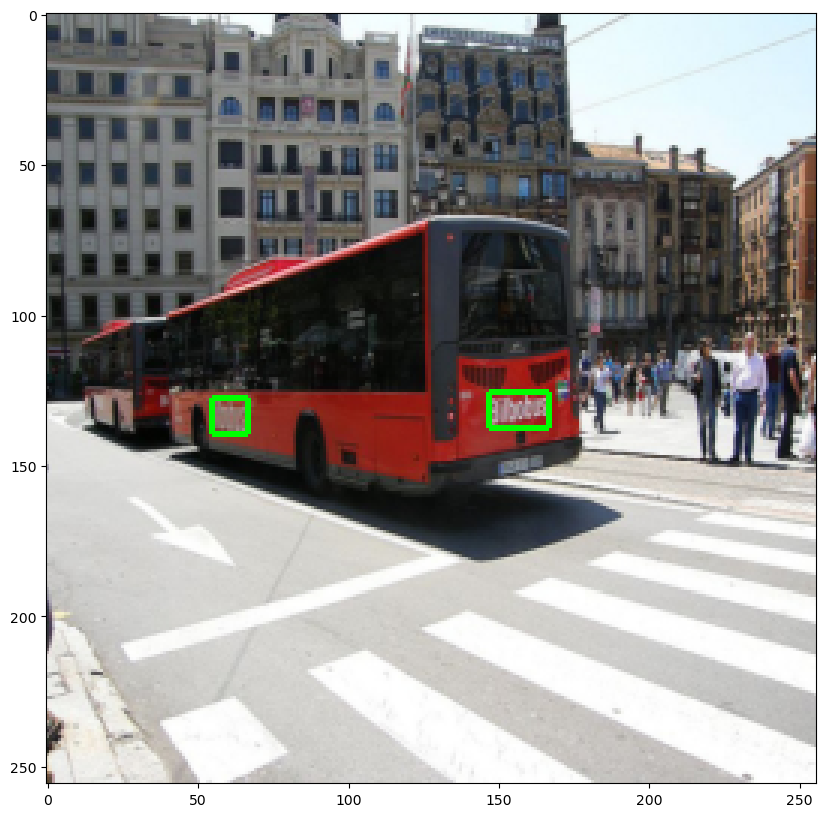

In [12]:
rnd = lambda x: torch.round(x).long()

plt.imshow(draw_boxes(
    x.permute(1, 2, 0).numpy(), rnd(y[:, 0]), rnd(y[:, 1]), rnd(y[:, 2]), rnd(y[:, 3]) 
))
#plt.imshow(x.permute(1, 2, 0))

In [13]:
from abbyy_course_cvdl_t2.network import CenterNet
from abbyy_course_cvdl_t2.convert import ObjectsToPoints
from abbyy_course_cvdl_t2.loss import CenterNetLoss
import os

In [14]:
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [15]:
net = CenterNet(head_kwargs={'c_classes': 1}, nms_kwargs={'kernel_size': 5})
crit = CenterNetLoss(obj_to_points=ObjectsToPoints(num_classes=1))

In [16]:
net = train(ds_text, net=net, criterion=crit, batch_size=128, epochs=100, device=torch.device('cuda:0'), lr=1e-3)

/home/ichuviliaeva/cv_hw3/course_cvdl/task2/abbyy_course_cvdl_t2/convert.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  h = torch.tensor(objects[:, :, 2]).to(objects.device)
/home/ichuviliaeva/cv_hw3/course_cvdl/task2/abbyy_course_cvdl_t2/convert.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.tensor(objects[:, :, 3]).to(objects.device)


epoch 0|0; total loss:2378.6728515625
last losses: [35679.34765625, 0.2468537986278534, 0.4962521195411682]
epoch 0|15; total loss:2058.97119140625
last losses: [599.7337646484375, 0.2889132499694824, 0.30143770575523376]
epoch 0|30; total loss:632.7098999023438
last losses: [519.7880249023438, 0.2447989135980606, 0.25572073459625244]
epoch 0|45; total loss:473.5480041503906
last losses: [453.7532958984375, 0.24504384398460388, 0.29471731185913086]
epoch 0|60; total loss:425.8401184082031
last losses: [428.06048583984375, 0.24739675223827362, 0.33514970541000366]
epoch 0|75; total loss:377.3201599121094
last losses: [377.1931457519531, 0.24320082366466522, 0.2577013373374939]
epoch 0|90; total loss:372.46685791015625
last losses: [355.4754333496094, 0.2414155751466751, 0.21172583103179932]
epoch 0|105; total loss:350.1305847167969
last losses: [332.4537658691406, 0.24802638590335846, 0.26168325543403625]
epoch 0|120; total loss:352.64044189453125
last losses: [360.5226745605469, 0.2341

epoch 7|15; total loss:133.248046875
last losses: [135.648193359375, 0.22764615714550018, 0.20139780640602112]
epoch 7|30; total loss:125.78815460205078
last losses: [141.4174041748047, 0.22922532260417938, 0.27181893587112427]
epoch 7|45; total loss:126.79448699951172
last losses: [145.86801147460938, 0.22892658412456512, 0.27524086833000183]
epoch 7|60; total loss:129.09024047851562
last losses: [120.26324462890625, 0.20942896604537964, 0.2420329451560974]
epoch 7|75; total loss:141.22637939453125
last losses: [152.0953369140625, 0.24021051824092865, 0.2400742471218109]
epoch 7|90; total loss:135.568603515625
last losses: [129.90013122558594, 0.22908799350261688, 0.24737054109573364]
epoch 7|105; total loss:140.6407928466797
last losses: [148.76905822753906, 0.23245741426944733, 0.2613731026649475]
epoch 7|120; total loss:141.40359497070312
last losses: [149.0071258544922, 0.23911750316619873, 0.22920791804790497]
epoch 7|135; total loss:147.03514099121094
last losses: [109.033287048

epoch 14|30; total loss:41.047847747802734
last losses: [50.29191207885742, 0.2527499794960022, 0.2793373167514801]
epoch 14|45; total loss:36.57522964477539
last losses: [43.23109436035156, 0.24797384440898895, 0.2656565308570862]
epoch 14|60; total loss:40.43290710449219
last losses: [39.17763137817383, 0.24542878568172455, 0.27686721086502075]
epoch 14|75; total loss:37.60957717895508
last losses: [35.130470275878906, 0.22490330040454865, 0.20164936780929565]
epoch 14|90; total loss:38.40871810913086
last losses: [33.972145080566406, 0.24712926149368286, 0.2148524820804596]
epoch 14|105; total loss:40.076419830322266
last losses: [43.988563537597656, 0.24916110932826996, 0.26722002029418945]
epoch 14|120; total loss:44.13777160644531
last losses: [50.5757942199707, 0.22874298691749573, 0.20291872322559357]
epoch 14|135; total loss:42.570960998535156
last losses: [38.31901550292969, 0.2092355489730835, 0.20244364440441132]
epoch 15|0; total loss:2.195340633392334
last losses: [32.435

epoch 21|30; total loss:17.079729080200195
last losses: [14.163827896118164, 0.26710084080696106, 0.2746700346469879]
epoch 21|45; total loss:17.947538375854492
last losses: [14.215770721435547, 0.264541357755661, 0.2590853273868561]
epoch 21|60; total loss:17.535709381103516
last losses: [23.896652221679688, 0.24128425121307373, 0.21157027781009674]
epoch 21|75; total loss:17.451311111450195
last losses: [17.148204803466797, 0.21863022446632385, 0.18934887647628784]
epoch 21|90; total loss:20.078020095825195
last losses: [18.82122802734375, 0.2488185465335846, 0.23590178787708282]
epoch 21|105; total loss:18.932125091552734
last losses: [20.482120513916016, 0.22131513059139252, 0.2085171341896057]
epoch 21|120; total loss:20.699626922607422
last losses: [17.29582405090332, 0.24589064717292786, 0.2579030692577362]
epoch 21|135; total loss:21.40699005126953
last losses: [22.140830993652344, 0.26401984691619873, 0.2472398281097412]
epoch 22|0; total loss:0.9715656638145447
last losses: [

epoch 28|30; total loss:13.546233177185059
last losses: [13.76196002960205, 0.2134106457233429, 0.28053268790245056]
epoch 28|45; total loss:12.905069351196289
last losses: [12.31379508972168, 0.23658964037895203, 0.23570823669433594]
epoch 28|60; total loss:12.413780212402344
last losses: [8.726330757141113, 0.24339410662651062, 0.22290800511837006]
epoch 28|75; total loss:11.819108963012695
last losses: [10.638444900512695, 0.2391587346792221, 0.2199212908744812]
epoch 28|90; total loss:12.824398040771484
last losses: [10.948094367980957, 0.2210243046283722, 0.18220427632331848]
epoch 28|105; total loss:13.941365242004395
last losses: [11.3502836227417, 0.24938809871673584, 0.268626868724823]
epoch 28|120; total loss:12.927854537963867
last losses: [10.658517837524414, 0.26449641585350037, 0.24717353284358978]
epoch 28|135; total loss:15.385513305664062
last losses: [14.89897346496582, 0.27538853883743286, 0.2616935074329376]
epoch 29|0; total loss:0.5518863201141357
last losses: [7.

epoch 35|30; total loss:8.348934173583984
last losses: [10.927244186401367, 0.24136215448379517, 0.22103208303451538]
epoch 35|45; total loss:8.312463760375977
last losses: [6.7320356369018555, 0.22878296673297882, 0.1979333758354187]
epoch 35|60; total loss:7.667285442352295
last losses: [8.0389404296875, 0.20254398882389069, 0.202076256275177]
epoch 35|75; total loss:8.127267837524414
last losses: [7.328307151794434, 0.195367693901062, 0.19550684094429016]
epoch 35|90; total loss:8.5196533203125
last losses: [7.924680709838867, 0.24341413378715515, 0.23602448403835297]
epoch 35|105; total loss:8.208142280578613
last losses: [8.401556968688965, 0.22278332710266113, 0.26828181743621826]
epoch 35|120; total loss:9.025811195373535
last losses: [7.518921375274658, 0.2570449113845825, 0.2519886791706085]
epoch 35|135; total loss:10.103673934936523
last losses: [10.367547988891602, 0.2612229585647583, 0.2639070749282837]
epoch 36|0; total loss:0.42471182346343994
last losses: [5.95322036743

epoch 42|45; total loss:6.446313381195068
last losses: [5.816653251647949, 0.2355007827281952, 0.21590673923492432]
epoch 42|60; total loss:7.48805570602417
last losses: [5.992018699645996, 0.24007391929626465, 0.21654394268989563]
epoch 42|75; total loss:7.156088352203369
last losses: [4.518678665161133, 0.23845376074314117, 0.2154262810945511]
epoch 42|90; total loss:8.40214729309082
last losses: [7.4114460945129395, 0.2660680413246155, 0.24821268022060394]
epoch 42|105; total loss:8.015676498413086
last losses: [5.0400543212890625, 0.2618897557258606, 0.2441568523645401]
epoch 42|120; total loss:9.480374336242676
last losses: [6.713314533233643, 0.26843032240867615, 0.23650038242340088]
epoch 42|135; total loss:10.811670303344727
last losses: [8.897977828979492, 0.2325899600982666, 0.2797123193740845]
epoch 43|0; total loss:0.40562209486961365
last losses: [5.618446350097656, 0.23119890689849854, 0.2346859574317932]
epoch 43|15; total loss:8.05069637298584
last losses: [6.7550368309

epoch 49|60; total loss:16.360885620117188
last losses: [16.38134765625, 0.22110912203788757, 0.20345956087112427]
epoch 49|75; total loss:15.904671669006348
last losses: [17.756305694580078, 0.24335072934627533, 0.2392662763595581]
epoch 49|90; total loss:13.94992446899414
last losses: [18.746437072753906, 0.2234235256910324, 0.1953352689743042]
epoch 49|105; total loss:14.732477188110352
last losses: [14.702116012573242, 0.23541948199272156, 0.2297382652759552]
epoch 49|120; total loss:13.155180931091309
last losses: [12.6469144821167, 0.22095434367656708, 0.19891205430030823]
epoch 49|135; total loss:14.54434585571289
last losses: [15.261575698852539, 0.2438412457704544, 0.23491306602954865]
epoch 50|0; total loss:0.39682409167289734
last losses: [5.47818660736084, 0.24411728978157043, 0.23005716502666473]
epoch 50|15; total loss:5.641468524932861
last losses: [2.966752290725708, 0.2529953122138977, 0.24183917045593262]
epoch 50|30; total loss:4.989503383636475
last losses: [2.79965

epoch 56|60; total loss:2.9741127490997314
last losses: [1.3032108545303345, 0.24733415246009827, 0.28116023540496826]
epoch 56|75; total loss:2.9914419651031494
last losses: [1.1893726587295532, 0.21901309490203857, 0.22220472991466522]
epoch 56|90; total loss:4.219662189483643
last losses: [1.6779052019119263, 0.23562371730804443, 0.2403278350830078]
epoch 56|105; total loss:5.028191089630127
last losses: [4.385492324829102, 0.23973169922828674, 0.2226889580488205]
epoch 56|120; total loss:6.9828009605407715
last losses: [8.732969284057617, 0.2450714409351349, 0.29642435908317566]
epoch 56|135; total loss:7.593307018280029
last losses: [6.091435432434082, 0.2220725268125534, 0.1812107115983963]
epoch 57|0; total loss:0.5181717872619629
last losses: [7.291429042816162, 0.24129065871238708, 0.23985658586025238]
epoch 57|15; total loss:7.185530185699463
last losses: [4.770564079284668, 0.24988047778606415, 0.24253469705581665]
epoch 57|30; total loss:7.842516899108887
last losses: [7.69

epoch 63|75; total loss:4.8742852210998535
last losses: [2.7827939987182617, 0.2427772432565689, 0.23087693750858307]
epoch 63|90; total loss:5.572145462036133
last losses: [3.1875524520874023, 0.2259058952331543, 0.20878127217292786]
epoch 63|105; total loss:6.156214237213135
last losses: [5.02236270904541, 0.247390478849411, 0.22921808063983917]
epoch 63|120; total loss:5.801577568054199
last losses: [4.167825698852539, 0.23859551548957825, 0.2370314747095108]
epoch 63|135; total loss:6.156569957733154
last losses: [7.697890281677246, 0.23455177247524261, 0.23560410737991333]
epoch 64|0; total loss:0.3329624533653259
last losses: [4.485896110534668, 0.2467242181301117, 0.2618166506290436]
epoch 64|15; total loss:5.515312671661377
last losses: [7.297648906707764, 0.24238818883895874, 0.28380662202835083]
epoch 64|30; total loss:4.705910682678223
last losses: [4.896028995513916, 0.23150302469730377, 0.2615694999694824]
epoch 64|45; total loss:4.783463478088379
last losses: [4.029505729

epoch 70|90; total loss:5.753985404968262
last losses: [5.450155258178711, 0.2269667685031891, 0.22671234607696533]
epoch 70|105; total loss:4.982268333435059
last losses: [5.851439476013184, 0.24682700634002686, 0.2622378468513489]
epoch 70|120; total loss:5.329742431640625
last losses: [5.811700820922852, 0.22886289656162262, 0.2580558657646179]
epoch 70|135; total loss:5.80628776550293
last losses: [6.324267387390137, 0.2557494342327118, 0.2233068346977234]
epoch 71|0; total loss:0.2592836320400238
last losses: [3.449124336242676, 0.22988662123680115, 0.21024338901042938]
epoch 71|15; total loss:3.8311967849731445
last losses: [6.032292366027832, 0.24571743607521057, 0.19940757751464844]
epoch 71|30; total loss:3.759817123413086
last losses: [3.0294132232666016, 0.2525593638420105, 0.2061237394809723]
epoch 71|45; total loss:5.208993911743164
last losses: [6.950130939483643, 0.24100184440612793, 0.24240031838417053]
epoch 71|60; total loss:4.6292290687561035
last losses: [1.93088006

epoch 77|105; total loss:4.195502281188965
last losses: [6.172138690948486, 0.23276790976524353, 0.24180158972740173]
epoch 77|120; total loss:5.397489547729492
last losses: [3.6979849338531494, 0.24933770298957825, 0.2238965779542923]
epoch 77|135; total loss:6.529215335845947
last losses: [7.751389980316162, 0.21712467074394226, 0.2235317826271057]
epoch 78|0; total loss:0.23358674347400665
last losses: [3.0175859928131104, 0.24779126048088074, 0.23842358589172363]
epoch 78|15; total loss:3.4365787506103516
last losses: [1.6487226486206055, 0.24941864609718323, 0.25684964656829834]
epoch 78|30; total loss:2.786747694015503
last losses: [2.19753360748291, 0.24511505663394928, 0.261913925409317]
epoch 78|45; total loss:3.475350856781006
last losses: [2.6005637645721436, 0.23145954310894012, 0.27870678901672363]
epoch 78|60; total loss:3.955535650253296
last losses: [4.100543975830078, 0.23991312086582184, 0.24396753311157227]
epoch 78|75; total loss:4.080653667449951
last losses: [4.12

epoch 84|105; total loss:3.9913954734802246
last losses: [3.5386953353881836, 0.2481193244457245, 0.31887179613113403]
epoch 84|120; total loss:5.155263900756836
last losses: [6.280084133148193, 0.21998478472232819, 0.22373875975608826]
epoch 84|135; total loss:5.760653972625732
last losses: [8.2352933883667, 0.20093218982219696, 0.21998187899589539]
epoch 85|0; total loss:0.1608237475156784
last losses: [1.9497251510620117, 0.2549598217010498, 0.20767125487327576]
epoch 85|15; total loss:3.558304786682129
last losses: [3.8845038414001465, 0.24979345500469208, 0.21648545563220978]
epoch 85|30; total loss:3.3880233764648438
last losses: [2.825596809387207, 0.23167265951633453, 0.2294694483280182]
epoch 85|45; total loss:3.648308753967285
last losses: [3.841184139251709, 0.2420646846294403, 0.25455307960510254]
epoch 85|60; total loss:4.042325973510742
last losses: [2.2497215270996094, 0.24218185245990753, 0.2560078501701355]
epoch 85|75; total loss:3.8484036922454834
last losses: [4.076

epoch 91|105; total loss:3.871415853500366
last losses: [4.296670913696289, 0.2334139049053192, 0.2443290650844574]
epoch 91|120; total loss:4.210681438446045
last losses: [2.677194356918335, 0.23195917904376984, 0.23783409595489502]
epoch 91|135; total loss:4.821685314178467
last losses: [6.464179039001465, 0.24564479291439056, 0.2790922522544861]
epoch 92|0; total loss:0.1262040138244629
last losses: [1.3902329206466675, 0.2519994378089905, 0.25082775950431824]
epoch 92|15; total loss:3.034703016281128
last losses: [2.754481315612793, 0.25062334537506104, 0.26952359080314636]
epoch 92|30; total loss:3.9072821140289307
last losses: [3.2394442558288574, 0.22605684399604797, 0.19875586032867432]
epoch 92|45; total loss:4.018516540527344
last losses: [2.8022420406341553, 0.22550281882286072, 0.21516942977905273]
epoch 92|60; total loss:3.8460869789123535
last losses: [2.425570487976074, 0.2565624713897705, 0.2657325267791748]
epoch 92|75; total loss:4.297512531280518
last losses: [5.3073

epoch 98|105; total loss:4.024427890777588
last losses: [4.09998893737793, 0.24529454112052917, 0.25475013256073]
epoch 98|120; total loss:4.129101753234863
last losses: [5.556734085083008, 0.2602795958518982, 0.22650808095932007]
epoch 98|135; total loss:3.3692474365234375
last losses: [2.198007583618164, 0.2205769568681717, 0.21352910995483398]
epoch 99|0; total loss:0.20167195796966553
last losses: [2.5457375049591064, 0.2392697036266327, 0.2400720715522766]
epoch 99|15; total loss:2.8229563236236572
last losses: [3.214116096496582, 0.24408027529716492, 0.2481544315814972]
epoch 99|30; total loss:2.452605724334717
last losses: [2.7161972522735596, 0.249611496925354, 0.18346990644931793]
epoch 99|45; total loss:2.3956716060638428
last losses: [0.6121622323989868, 0.21818703413009644, 0.20781061053276062]
epoch 99|60; total loss:3.000438690185547
last losses: [2.349738359451294, 0.24918071925640106, 0.2549651861190796]
epoch 99|75; total loss:2.672926664352417
last losses: [1.42794835

In [17]:
torch.save(net, 'centernet_coco.pth')

In [18]:
with torch.no_grad():
    yp_heat = net(x[None].to('cuda:0')).cpu()    
    yp = net(x[None].to('cuda:0'), return_objects=True).cpu()

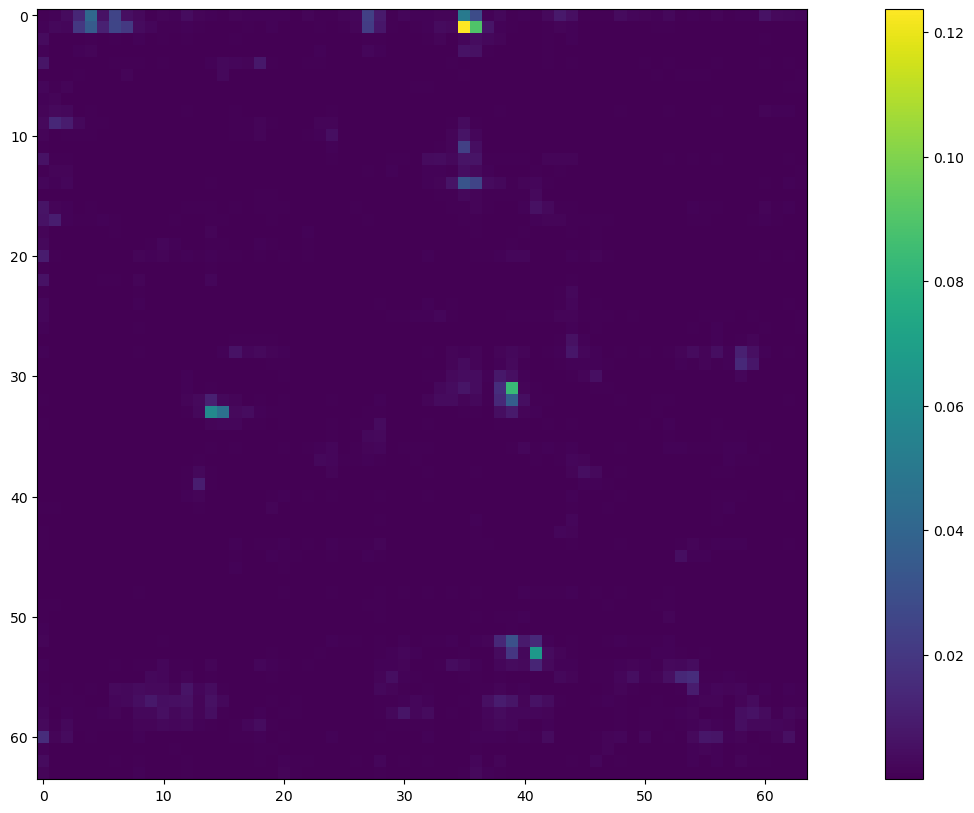

In [19]:
plt.imshow(yp_heat[0, 0])
plt.colorbar()

In [20]:
yp[0][:20]

tensor([[5.9181e+00, 1.4223e+02, 8.5870e+00, 1.4221e+01, 0.0000e+00, 1.2365e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e

In [21]:
y[:6]

tensor([[133.8933,  60.5600,  12.5333,  13.4400,   0.0000,   1.0000],
        [131.5200, 156.7800,  11.5200,  19.8800,   0.0000,   1.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


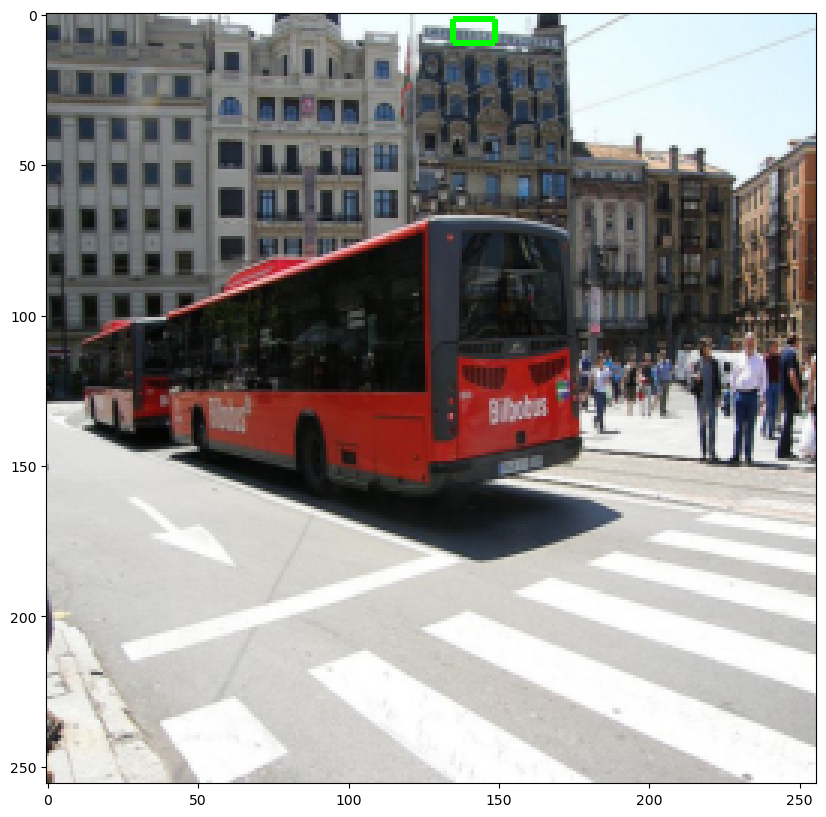

In [22]:
rnd = lambda x: torch.round(x).long()

plt.imshow(draw_boxes(
    x.permute(1, 2, 0).numpy(), rnd(yp[0, :3, 0]), rnd(yp[0, :3, 1]), rnd(yp[0, :3, 2]), rnd(yp[0, :3, 3]) 
));